In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np



candlestick_frame = 12
pnl_threshold = 3

ohlc_df = pd.read_csv('../../data/ETHUSDT-ohlcv.csv')
ohlc_df['LOGRET_1'] = list(ohlc_df.ta.log_return())
ohlc_df = ohlc_df.dropna()
LOGRET_1 = list(ohlc_df['LOGRET_1'])

dta_lst = []
tot = len(ohlc_df)


def get_sig(df):
    ts = list(df['time'])
    open = list(df['open'])
    high = list(df['high'])
    low = list(df['low'])
    close = list(df['close'])
    volume = list(df['volume'])
    tot = len(ts)
    long_runup_lst = []
    long_drawdown_lst = []
    short_runup_lst = []
    short_drawdown_lst = []

    for idx in range(tot):
        if (idx >= candlestick_frame) and (idx <= tot - candlestick_frame):
            max_high = max(high[idx+1:idx+candlestick_frame])
            min_low = min(low[idx+1:idx+candlestick_frame])
            entry_price = open[idx+1]
            long_runup_lst.append(round((max_high*100/entry_price)-100, 6))
            long_drawdown_lst.append(round((min_low*100/entry_price)-100, 6))
            short_runup_lst.append(round((entry_price*100/min_low)-100, 6))
            short_drawdown_lst.append(round((entry_price*100/max_high)-100, 6))
        else:
            long_runup_lst.append(0)
            long_drawdown_lst.append(0)
            short_runup_lst.append(0)
            short_drawdown_lst.append(0)     


    long=[]
    short=[]
    dont_trade=[]
    signal = []

    for idx in range(tot):
        if (idx >= candlestick_frame) and (idx <= tot - candlestick_frame):
            if long_runup_lst[idx] >= pnl_threshold:
                signal.append('long')
            elif short_runup_lst[idx] >= pnl_threshold:
                signal.append('short')
            else:
                signal.append('dont_trade')
        else:
            signal.append('dont_trade')


    # df['signal'] = signal
    return signal[candlestick_frame:]


sig = get_sig(ohlc_df)
for idx in range(candlestick_frame, tot, 1):
    app = {}
    for i in range(candlestick_frame):
        app[i] = LOGRET_1[idx-i]
    dta_lst.append(app)

df = pd.DataFrame(dta_lst)

df.to_csv(f'../../data/df.csv', index=False)
y = pd.DataFrame(sig).to_csv('../../data/y.csv', index=False)

In [2]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np


df = pd.read_csv('../../data/df.csv')
df.head()

0         1         2         3         4         5         6  \
0 -0.000108 -0.002288  0.002011  0.001594  0.003397 -0.002540  0.000313   
1 -0.002185 -0.000108 -0.002288  0.002011  0.001594  0.003397 -0.002540   
2 -0.002808 -0.002185 -0.000108 -0.002288  0.002011  0.001594  0.003397   
3 -0.002857 -0.002808 -0.002185 -0.000108 -0.002288  0.002011  0.001594   
4  0.001533 -0.002857 -0.002808 -0.002185 -0.000108 -0.002288  0.002011   

          7         8         9        10        11  
0 -0.001781  0.000128 -0.001501  0.005098  0.000391  
1  0.000313 -0.001781  0.000128 -0.001501  0.005098  
2 -0.002540  0.000313 -0.001781  0.000128 -0.001501  
3  0.003397 -0.002540  0.000313 -0.001781  0.000128  
4  0.001594  0.003397 -0.002540  0.000313 -0.001781

In [3]:
len(df)

20500

In [4]:
y = pd.read_csv('../../data/y.csv')
len(y)

20500

In [5]:
df["id"] = df.index
df = df.melt(id_vars="id", var_name="time").sort_values(["id", "time"]).reset_index(drop=True)
df.to_csv('../../data/df_id_time.csv', index=False)
df.head()

id time     value
0   0    0 -0.000108
1   0    1 -0.002288
2   0   10  0.005098
3   0   11  0.000391
4   0    2  0.002011

In [6]:
# only use the first 500 ids to speed up the processing
X = extract_features(df[df["id"] < 20500], column_id="id", column_sort="time", impute_function=impute)

Feature Extraction: 100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


In [7]:
len(df)

246000

In [8]:
len(y)

20500

In [10]:
X

value__variance_larger_than_standard_deviation  \
0                                                 0.0   
1                                                 0.0   
2                                                 0.0   
3                                                 0.0   
4                                                 0.0   
...                                               ...   
20495                                             0.0   
20496                                             0.0   
20497                                             0.0   
20498                                             0.0   
20499                                             0.0   

       value__has_duplicate_max  value__has_duplicate_min  \
0                           0.0                       0.0   
1                           0.0                       0.0   
2                           0.0                       0.0   
3                           0.0                       0.0   
4                           0.0                       0.0   
...                         ...                       ...   
20495                       0.0                       0.0   
20496                       0.0                       0.0   
20497                       0.0                       0.0   
20498                       0.0                       0.0   
20499                       0.0                       0.0   

       value__has_duplicate  value__sum_values  value__abs_energy  \
0                       0.0           0.004715           0.000062   
1                       0.0           0.002139           0.000066   
2                       0.0          -0.005767           0.000048   
3                       0.0          -0.007123           0.000054   
4                       0.0          -0.005718           0.000056   
...                     ...                ...                ...   
20495                   0.0           0.001428           0.000008   
20496                   0.0           0.000819           0.000009   
20497                   0.0           0.000434           0.000008   
20498                   0.0           0.000978           0.000007   
20499                   0.0           0.000752           0.000007   

       value__mean_abs_change  value__mean_change  \
0                    0.002958           -0.000127   
1                    0.003343            0.000210   
2                    0.002322            0.000093   
3                    0.002261            0.000288   
4                    0.002547           -0.000370   
...                       ...                 ...   
20495                0.000921           -0.000116   
20496                0.001108            0.000129   
20497                0.001197           -0.000075   
20498                0.001104            0.000070   
20499                0.001098            0.000024   

       value__mean_second_derivative_central  value__median  ...  \
0                                   0.000028       0.000221  ...   
1                                  -0.000008       0.000010  ...   
2                                  -0.000136      -0.000805  ...   
3                                   0.000140      -0.000944  ...   
4                                  -0.000077      -0.000944  ...   
...                                      ...            ...  ...   
20495                              -0.000109       0.000192  ...   
20496                              -0.000032       0.000192  ...   
20497                               0.000081       0.000192  ...   
20498                              -0.000087       0.000192  ...   
20499                               0.000043       0.000079  ...   

       value__fourier_entropy__bins_5  value__fourier_entropy__bins_10  \
0                            1.277034                         1.475076   
1                            1.277034                         1.475076   
2                            1.277034                         1.747868   
3         

In [9]:
X['signal'] = y

In [10]:
X.to_csv('../../data/X.csv', index=False)

In [11]:
import random


long_indices = X[X['signal'].str.contains('long', case=False)].index
short_indices = X[X['signal'].str.contains('short', case=False)].index
dont_trade_indices = list(X[X['signal'].str.contains('dont_trade', case=False)].index)
num_indices_to_pick  = len(dont_trade_indices) - min([len(long_indices), len(short_indices)])
random_indices = random.sample(dont_trade_indices, num_indices_to_pick)
X = X.drop(random_indices)

X.reset_index(drop=True, inplace=True)
X.to_csv('../../data/X.csv', index=False)

In [16]:
X

value__variance_larger_than_standard_deviation  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
4222                                             0.0   
4223                                             0.0   
4224                                             0.0   
4225                                             0.0   
4226                                             0.0   

      value__has_duplicate_max  value__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
4222                       0.0                       0.0   
4223                       0.0                       0.0   
4224                       0.0                       0.0   
4225                       0.0                       0.0   
4226                       0.0                       0.0   

      value__has_duplicate  value__sum_values  value__abs_energy  \
0                      0.0          -0.012294           0.000090   
1                      0.0           0.008180           0.000026   
2                      0.0           0.005439           0.000020   
3                      0.0           0.009002           0.000190   
4                      0.0           0.004799           0.000196   
...                    ...                ...                ...   
4222                   0.0           0.001637           0.000018   
4223                   0.0           0.002834           0.000016   
4224                   0.0          -0.002330           0.000008   
4225                   0.0          -0.000744           0.000002   
4226                   0.0           0.003425           0.000008   

      value__mean_abs_change  value__mean_change  \
0                   0.003558           -0.000336   
1                   0.001748            0.000098   
2                   0.001575            0.000029   
3                   0.004721           -0.000906   
4                   0.006480            0.000204   
...                      ...                 ...   
4222                0.001535           -0.000052   
4223                0.001381           -0.000012   
4224                0.000993           -0.000152   
4225                0.000485           -0.000079   
4226                0.000883           -0.000181   

      value__mean_second_derivative_central  value__median  ...  \
0                                 -0.000132      -0.001738  ...   
1                                  0.000069       0.000920  ...   
2                                  0.000058       0.000573  ...   
3                                  0.000061      -0.000499  ...   
4                                 -0.000511      -0.000642  ...   
...                                     ...            ...  ...   
4222                               0.000007      -0.000338  ...   
4223                              -0.000092      -0.000209  ...   
4224                              -0.000173      -0.000280  ...   
4225                               0.000031      -0.000096  ...   
4226                               0.000076       0.000334  ...   

      value__fourier_entropy__bins_10  value__fourier_entropy__bins_100  \
0                            1.277034                          1.747868   
1                            1.475076                          1.747868   
2                            1.277034                          1.945910   
3                            1.549826                          1.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


Processing:   0%|          | 0/57 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


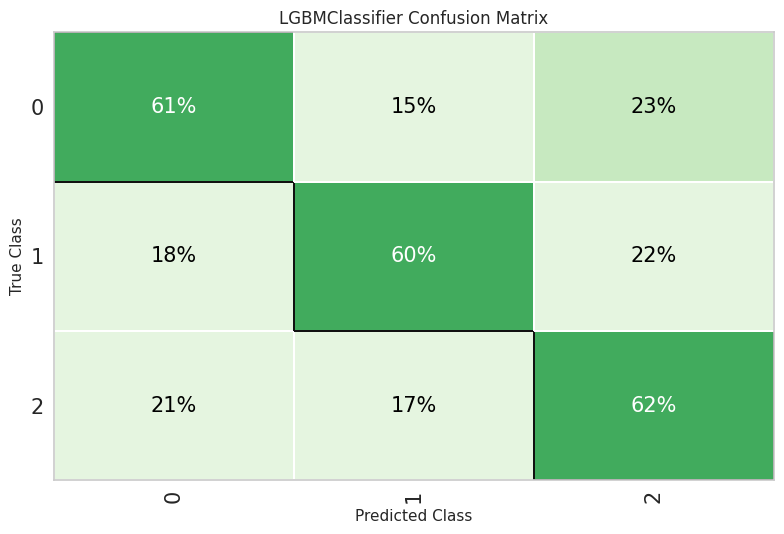

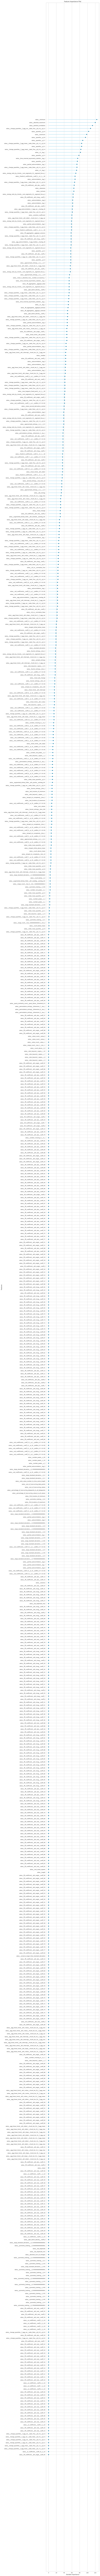

In [12]:


from pycaret.classification import load_model, predict_model
from pycaret.classification import *
from pycaret.classification import ClassificationExperiment
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd


exp = ClassificationExperiment()
dataset_path = '../../data/'
data = pd.read_csv(f'{dataset_path}X.csv')
# data.replace([np.inf, -np.inf], np.nan, inplace=True)
s = setup(data, target = 'signal', session_id = 123, use_gpu=True)
# model = create_model(LGBMClassifier())
model = compare_models(exclude='gbc')
# validation_scores = pull()
# accuracy_mean = validation_scores['Accuracy']['Mean']

# save pipeline
model_name = 'tsfresh'
save_model(model, f'../../models/{model_name}')
# print(f'{model_name} model saved. accuracy_mean={accuracy_mean}')
plot_model(model, plot = 'confusion_matrix', plot_kwargs = {'percent': True})
plot_model(model, plot = 'feature_all')